# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [9]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=a3c2132ed52c0bd8b11446a02b01b57f0d58ac545c8c99ec89b6f8050126a4a4
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [1]:
# Your code here.
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
batch_size = 32
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

# In case we want to pretty-print classifications.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 28612796.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# CIFAR10 is not a subset of CIFAR100, the only possible overlapping is:
# Truck (ID) => Pickup Truck (OOD)
ds_fake = CIFAR100(root='./data', train=False, download=True, transform=transform)
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 169001437/169001437 [00:05<00:00, 29526584.01it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [4]:
# CNN adapted from my implementation in the first lab
class down_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Convolution layer that does not reduce input size
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), padding=1)
        # Polling layer for input size reduction
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.conv(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.relu(x)
        return x



class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial layers to reduce input size
        num_channels = 3
        hidden_channels = 256
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=hidden_channels, kernel_size=(3,3), stride=1),
            nn.MaxPool2d(3,stride=2, padding=1),
            #down_block(hidden_channels, hidden_channels),
        )
        # Single input size reduction block
        self.d = down_block(hidden_channels, hidden_channels)
        # Size maintaining convolution
        self.conv = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=(3,3), padding=1)
        # Classification Layer
        self.classify = nn.Linear(hidden_channels, 10)
        # Layer for feature extraction
        self.final_conv = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=(2,2))
        # Global Average Pooling
        self.gap = torch.nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        x = self.layers(x)
        x = F.relu(self.conv(x))
        x = F.relu(self.conv(x))
        x = F.relu(self.final_conv(x))
        x = self.gap(x)
        x = torch.flatten(x,start_dim=1)
        x = self.classify(x)
        return x

In [5]:
# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    probs = []
    with torch.no_grad():
        for (Xs, _) in dl:

            logits.append(model(Xs.to(device)).cpu().numpy())
            probs.append(F.softmax(torch.tensor(logits[-1])))
    return np.vstack(logits),np.vstack(probs)

In [6]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).

def plot_ood_hist(model, dl_test, dl_fake):

    logits_ID, probs_ID = collect_logits(model, dl_test)
    logits_OOD, probs_OOD = collect_logits(model, dl_fake)
    # Plot the *distribution* of max logit outputs.
    _ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
    _ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
    plt.legend()
    max_probs_ID = probs_ID.max(1)
    max_probs_OOD = probs_OOD.max(1)



### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


In [7]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import torch.nn.functional as F
def plot_ood_curves(model, dl_test, dl_fake, t = 0):
    logits_ID, probs_ID = collect_logits(model, dl_test)
    logits_OOD, probs_OOD = collect_logits(model, dl_fake)

    # softmax
    if t != 0:
        samples = np.concatenate( (np.array(probs_ID.max(1)), np.array(logits_OOD.max(1))))
    #samples = np.concatenate( (max_probs_ID, max_probs_OOD))
    # logits -> work better
    else:
        samples = np.concatenate( (np.array(logits_ID.max(1)), np.array(logits_OOD.max(1))))

    labels = np.concatenate((np.ones(len(logits_ID),dtype=int), np.zeros(len(logits_OOD), dtype=int)) )


    RocCurveDisplay.from_predictions(labels,samples)
    PrecisionRecallDisplay.from_predictions(labels, samples)

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [8]:
# Your code here.
def FGSM(model, x, y, criterion, eps, targeted = False):
    x.requires_grad_()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    gradient = x.grad.sign_()
    # If target we want to go toward the target
    if targeted:
        gradient = -gradient
    adv = x + eps * gradient
    return adv.detach()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [18]:
import wandb
from tqdm import tqdm
def train_robust(model, device, epochs, lr, adversarial = False, softmax = False, log = None):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Main training loop.
    train_bar = tqdm(range(epochs),desc="Epoch: 0")
    for epoch in train_bar:
        running_loss = 0.0
        # Iterate over all batches.
        for Xs, ys in dl_train:
            Xs = Xs.to(device)
            ys = ys.to(device)

            # Train step
            optimizer.zero_grad()
            outputs = model(Xs)
            loss = criterion(outputs, ys)
            loss.backward()
            if adversarial:
                # Adversarial step
                Xs = Xs.detach()
                adv = FGSM(model, Xs, ys, criterion,0.1)
                outputs = model(adv)
                loss = criterion(outputs, ys)
                loss.backward()

            optimizer.step()

            # Track epoch loss.
            running_loss += loss.item()

        # Print average epoch loss
        train_bar.set_description(f'Epoch: {epoch + 1}')
        train_bar.set_postfix_str(f'Loss: {running_loss / len(dl_train):.3f}')
        if log == "wandb":
          wandb.log({"loss": loss})
    print('Finished Training')
    torch.save(model.state_dict(), './cifar10_CNN_robust.pth')
    return model



In [11]:
# Generate adversarial dataset from using an adversarial function e.g. FGSM
def gen_adv_data(dl_test, model, eps, adv_func, criterion, device, y_target = None):
    adv_data = []
    for x, y in dl_test:
        x = x.to(device)
        y = y.to(device)
        if y_target:
            y_target_batch = torch.full(y.shape, y_target,device=device)
            adv = adv_func(model=model, x = x, y = y_target_batch, criterion = criterion,eps = eps,targeted = True)
        else:
            adv = adv_func(model=model, x = x, y = y, criterion = criterion, eps = eps, targeted = False)
        adv_data.append( (adv, y) )
    return adv_data


In [12]:
# Simple validation accuracy
def eval_model(dl_test, model):
    sum = 0
    n = 0
    for x, y in dl_test:
        x = x.to(device)
        y = y.to(device)
        pred = model(x).argmax(1)
        sum += (pred == y).sum().item()
        n += y.shape[0]
    return sum / n


We train the model on the training set

In [43]:
model = CNN()
config={
    "learning_rate": 0.001,
    "dataset": "CIFAR10",
    "epochs": 30,
    "adversarial": False,
    "y_target": None
    }
#with wandb.init(project="OOD", config=config):
model = train_robust(model, device, config['epochs'],config['learning_rate'], adversarial=config['adversarial'])
dl_adv = gen_adv_data(dl_test, model, 0.1, FGSM, nn.CrossEntropyLoss(), "cuda", y_target=config['y_target'])
print(eval_model(dl_test, model))


Epoch: 30: 100%|██████████| 30/30 [12:17<00:00, 24.59s/it, Loss: 0.072]

Finished Training


0.8115


Test the trained model on the ood dataset

<ipython-input-5-553eb3deeb62>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs.append(F.softmax(torch.tensor(logits[-1])))


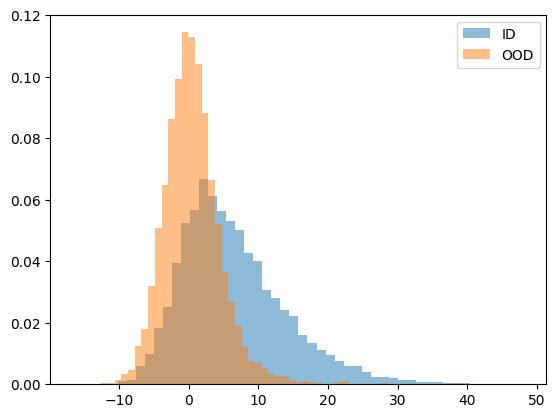

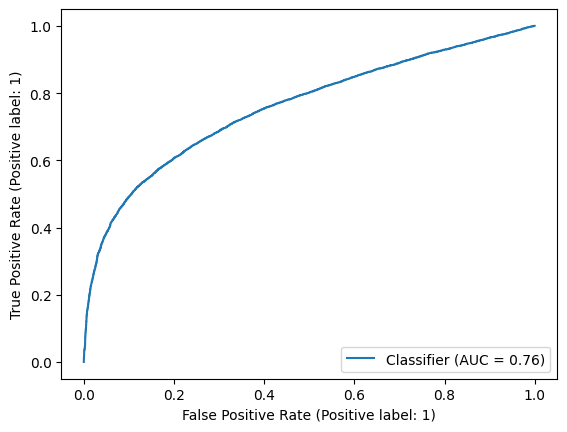

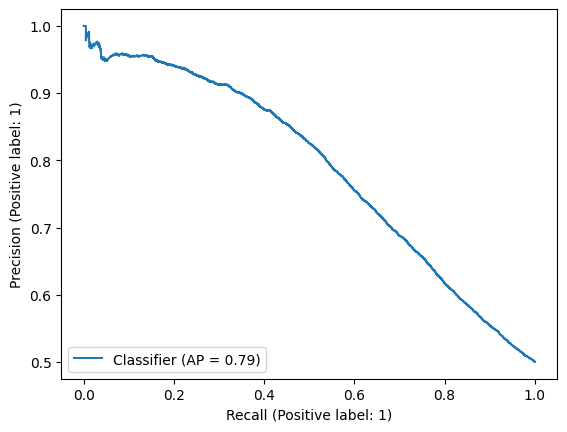

In [20]:
plot_ood_hist(model, dl_test, dl_fake)
plot_ood_curves(model, dl_test, dl_fake)

Considering the model has 80% accuracy on classification, the results are pretty good the model can distinguish the ID from the OOD on average 76% of the time.

<ipython-input-5-553eb3deeb62>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs.append(F.softmax(torch.tensor(logits[-1])))


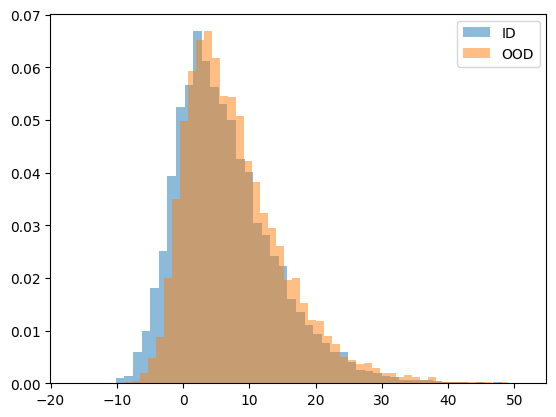

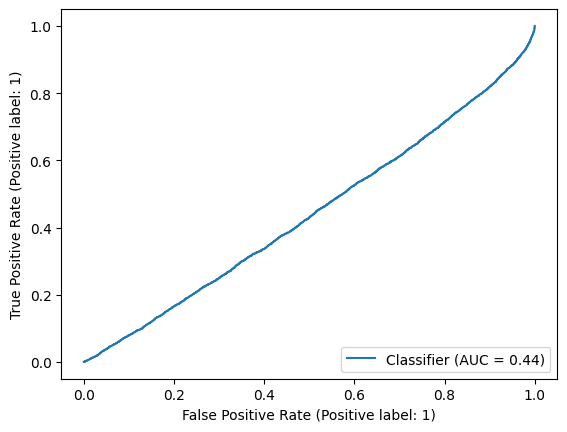

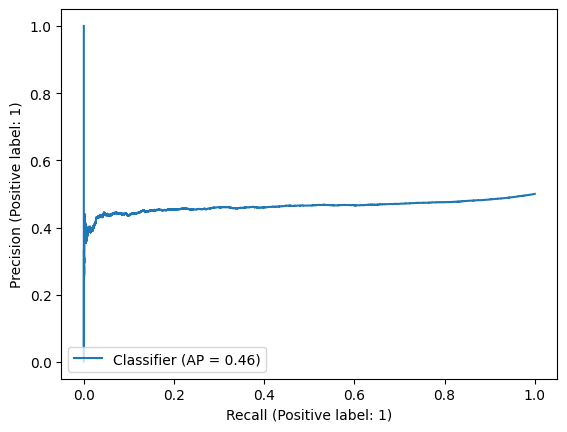

In [21]:
dl_adv = gen_adv_data(dl_test, model, 0.1, FGSM, nn.CrossEntropyLoss(), "cuda")
print(eval_model(dl_adv, model))
plot_ood_hist(model, dl_test, dl_adv)
plot_ood_curves(model, dl_test, dl_adv)

The FGSM is implemented correctly, generating an adversarial dataset the model can't distinguish ID from OOD just with 0.1 epsilon

We now try to augment the training set with adversarial data and see if the model becomes more robust

In [23]:
model_adv = CNN()
config={
    "learning_rate": 0.001,
    "dataset": "CIFAR10",
    "epochs": 30,
    "adversarial": True,
    "y_target": None
    }
#with wandb.init(project="OOD", config=config):
model_av = train_robust(model_adv, device, config['epochs'],config['learning_rate'], adversarial=config['adversarial'])
dl_adv = gen_adv_data(dl_test, model_adv, 0.1, FGSM, nn.CrossEntropyLoss(), "cuda", y_target=config['y_target'])
print(eval_model(dl_test, model_adv))

Epoch: 30: 100%|██████████| 30/30 [30:07<00:00, 60.23s/it, Loss: 0.434]

Finished Training


0.7724


<ipython-input-5-553eb3deeb62>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs.append(F.softmax(torch.tensor(logits[-1])))


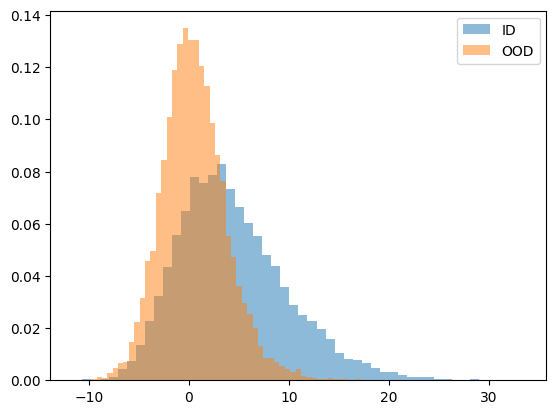

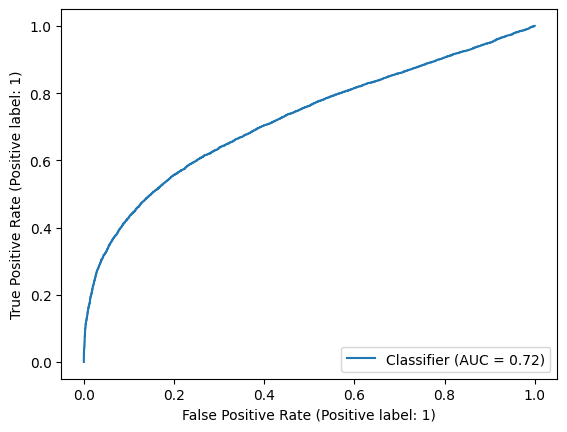

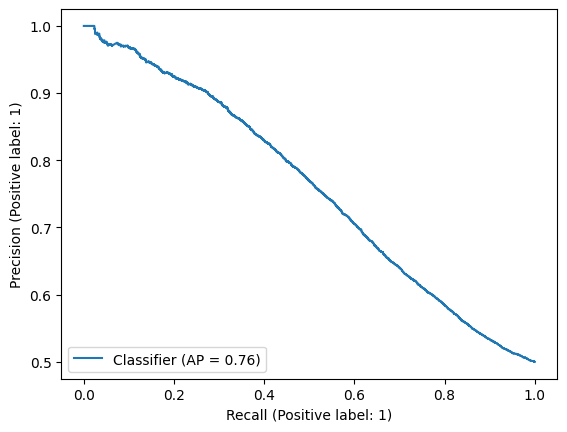

In [25]:
plot_ood_hist(model_adv, dl_test, dl_fake)
plot_ood_curves(model_adv, dl_test, dl_fake)

The model trained with adversarial data is a little worse than the original model, but this could be because of not enough training, after all we doubled the dataset and adversarial data is made to go against the gradient.

0.782


<ipython-input-5-553eb3deeb62>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs.append(F.softmax(torch.tensor(logits[-1])))


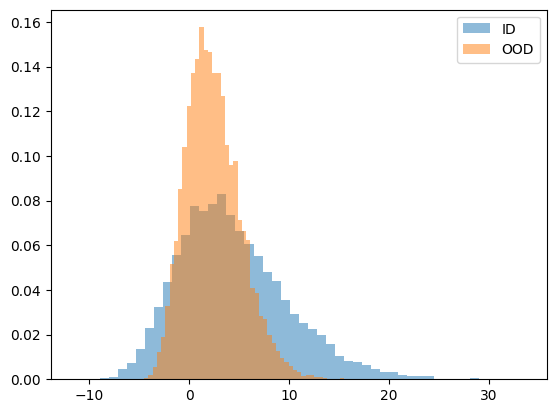

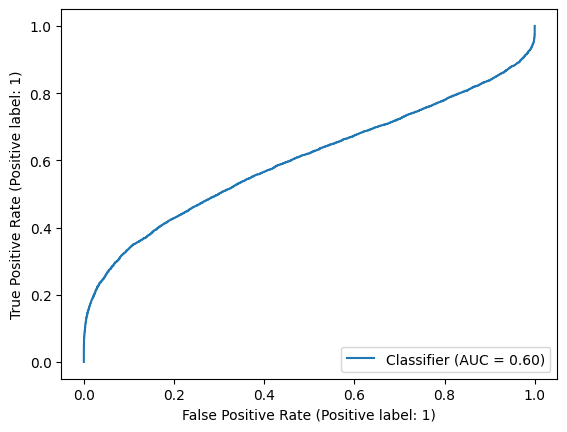

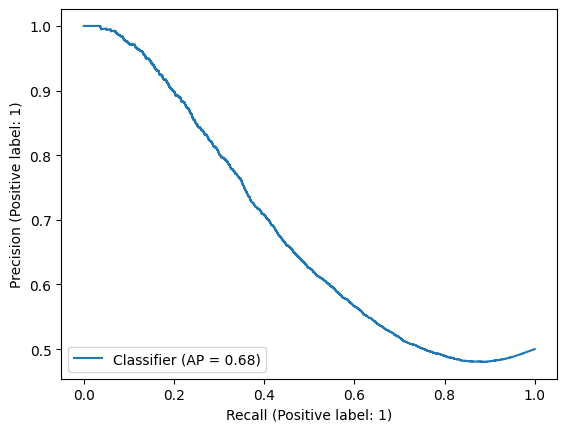

In [26]:
dl_adv = gen_adv_data(dl_test, model_adv, 0.1, FGSM, nn.CrossEntropyLoss(), "cuda")
print(eval_model(dl_adv, model_adv))
plot_ood_hist(model_adv, dl_test, dl_adv)
plot_ood_curves(model_adv, dl_test, dl_adv)

But training on adversarial data made it more robust against this specific type of attack, now it can dinstinguish a little between ID and OOD.

In [27]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [58]:
def normalize_img(img):
    img = img - np.min(img)
    img = img / np.max(img)
    img = np.uint8(255 * img)
    return img

def img_to_np(x):
    return x[0].permute(1,2,0).detach().cpu().numpy()
# Helper function to visualize results of the attack
def visualize_attack(dl,model, adv_func, eps, device, y_target = None, n = 1):
    cols = int(n // 2)
    rows = int(n // 2)
    fig, axs = plt.subplots(rows, cols)

    fig.suptitle("Classification on test images")
    fig.tight_layout()
    fig2, axs2 = plt.subplots(rows, cols)

    fig2.suptitle("Classification on adversarial images")
    fig2.tight_layout()
    i = 1
    row = 0
    col = 0
    for x, y in dl:
        x = x.to(device).unsqueeze(0)
        y = torch.tensor(y).to(device).unsqueeze(0)
        original_pred = model(x).argmax(1)
        if y_target:
            y_target_batch = torch.full(y.shape, y_target, device=device)
            adv = adv_func(model = model, x = x, y = y_target_batch, eps = eps,criterion = nn.CrossEntropyLoss(), targeted = True)
        else:
            adv = adv_func(model = model, x = x, y = y, eps = eps,criterion = nn.CrossEntropyLoss(), targeted = False)
        adv_pred = model(adv).argmax(1)

        axs[row, col].imshow(normalize_img(img_to_np(x)))
        if original_pred.item() == y.item():
            axs[row, col].set_title(f'{classes[original_pred.item()]}')
        else:
            axs[row, col].set_title(f'{classes[original_pred.item()]}',color='red')

        axs2[row, col].imshow(normalize_img(img_to_np(adv)))
        if adv_pred.item() == y.item():
            axs2[row, col].set_title(f'{classes[adv_pred.item()]}')
        else:
            axs2[row, col].set_title(f'{classes[adv_pred.item()]}',color='red')
        row += 1
        if(row == rows):
            row = 0
            col += 1
        i += 1

    plt.show()



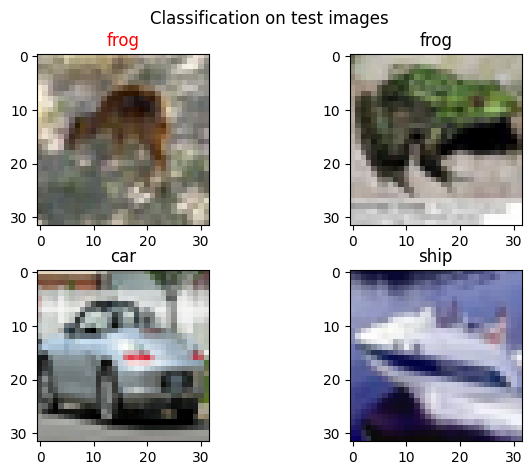

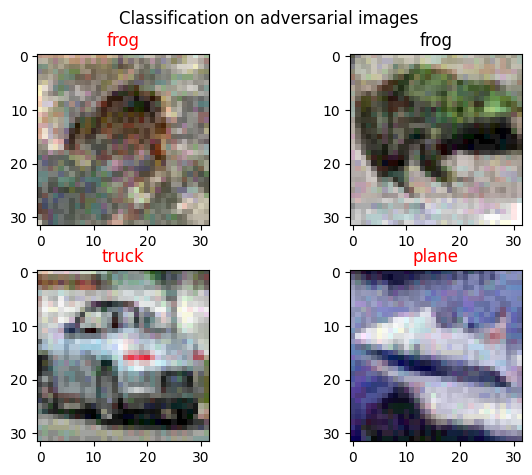

In [59]:
N = 4
sample = np.random.choice(range(len(ds_test)),size=N)
dl = torch.utils.data.Subset(ds_test, sample)

visualize_attack(dl, model, FGSM, 0.1, "cuda", n = N)

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


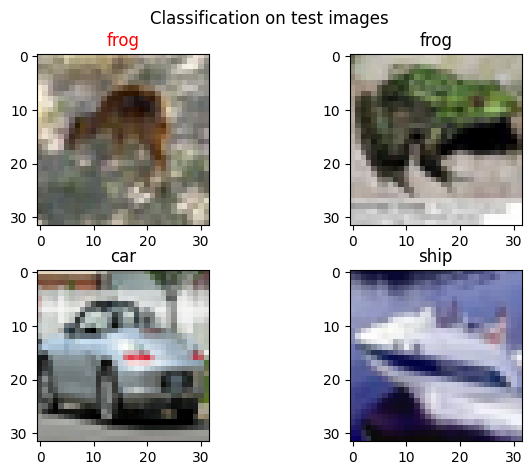

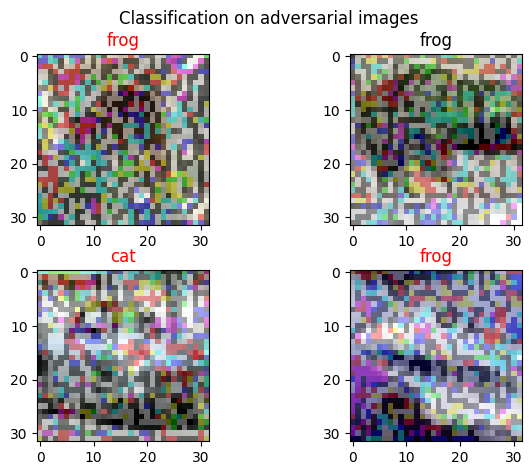

In [63]:
#We want to set the adversarial target as frog(label = 3)
visualize_attack(dl, model, FGSM, 0.5, "cuda",y_target=3, n = N )